In [ ]:
import numpy as np
import pandas as pd
import sympy as sym
import pybullet as p
import gym
import os
import random
import time
import pickle as plk
from robot_env_base_fija import robot_env
import matplotlib.pyplot as plt
import csv
import tensorflow as tf

from collections import deque

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, History
from MemorySaverCallback import MemorySaverCallback
from HistorySaverCallback import HistorySaverCallback

from rl.agents import DDPGAgent_mod
from rl.memory_mod import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint

Algoritmo DDPG

Entorno

In [ ]:
#Memoria
memory = SequentialMemory(limit=100000, initial_dict = None, window_length=1)

In [ ]:
#Registro del entorno
gym.envs.registration.register(
    id='RobotEnv-v0',  # Identificador único del entorno
    entry_point='robot_env_base_fija:robot_env',  # Módulo y clase del entorno
    max_episode_steps=250,  # Número máximo de pasos por episodio
)

# Crear el entorno
env = gym.make('RobotEnv-v0')


In [ ]:
#Número de acciones
nb_actions=6

In [7]:
#Dimensiones del vector de estado: (3,)
actor_model=Sequential()

actor_model.add(Flatten(input_shape=(3,))) #Capa de entrada
actor_model.add(Dense(256, activation='relu'))
actor_model.add(Dense(128, activation='relu'))
actor_model.add(Dense(64, activation='relu'))
actor_model.add(Dense(nb_actions, activation='tanh')) #Capa de salida
print(actor_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 256)               1024      
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 6)                 390       
                                                                 
Total params: 42,566
Trainable params: 42,566
Non-trainable params: 0
_________________________________________________________________
None


Critic

Implementación de la solución DDPG:

In [8]:
#Recibe como entrada el vector de estado y el vector de acciones

action_input=Input(shape=(nb_actions,), name='action_input')
obs_input=Input(shape=(3,), name='obs_input')

x=Concatenate()([action_input, obs_input])
print(x.shape)

x=Dense(9, input_shape=(9,), activation='relu')(x) #Capa de entrada
x=Dense(256, activation='relu')(x)
x=Dense(128, activation='relu')(x)
x=Dense(64, activation='relu')(x)
output=Dense(1, activation='linear')(x) #Capa de salida

critic_model = Model(inputs=[action_input, obs_input], outputs=output)

print(critic_model.summary())

(None, 9)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 action_input (InputLayer)      [(None, 6)]          0           []                               
                                                                                                  
 obs_input (InputLayer)         [(None, 3)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 9)            0           ['action_input[0][0]',           
                                                                  'obs_input[0][0]']              
                                                                                                  
 dense_4 (Dense)                (None, 9)            90          ['concatenate[0][0]

Solución DDPG

In [9]:
random_process=OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.3, mu=0., sigma=0.3) #Antes: theta=0.15, sigma=0.2

In [10]:
ddpg=DDPGAgent_mod(nb_actions=nb_actions, actor=actor_model, critic=critic_model, critic_action_input=action_input,
               memory=memory, gamma=0.99, batch_size=128, nb_steps_warmup_critic=130,
               nb_steps_warmup_actor=130, train_interval=1, memory_interval=1,
               delta_range=None, random_process=random_process,
               target_model_update=0.001)

ddpg.compile(Adam(learning_rate=.001), metrics=['mae'])

In [ ]:
weights_filename = 'ddpg_{}_weights.h5f'.format('RobotEnv-v0')
checkpoint_weights_filename = '.\checkpoint_weights_1\ddpg_RobotEnv-v0_weights_{step}.h5f'
log_filename = 'ddpg_{}_log_primera_parte.json'.format('RobotEnv-v0')
history=History()
memory_saver = MemorySaverCallback(memory=memory, save_dir =".\MemorySavings", save_interval=5000, initial_steps = 0)
history_saver = HistorySaverCallback(history=history, save_dir=".\historial_1", save_interval=10000, initial_steps = 0)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=5000)]
callbacks += [FileLogger(log_filename, interval=100)]
callbacks += [history]
callbacks += [memory_saver]
callbacks += [history_saver]



ddpg.fit(env=env, callbacks=callbacks, nb_steps=1000000, visualize=False, verbose=1, nb_max_episode_steps=250)

## Reanudar entrenamiento

In [ ]:
with open('.\MemorySavings\dict_260000.pkl', 'rb') as archivo:
    diccionario = plk.load(archivo)

memory = SequentialMemory(limit=100000, initial_dict = diccionario, window_length=1)


#Registro del entorno
gym.envs.registration.register(
    id='RobotEnv-v0',  # Identificador único del entorno
    entry_point='robot_env_base_fija:robot_env',  # Módulo y clase del entorno
    max_episode_steps=250,  # Número máximo de pasos por episodio
)

# Crear el entorno
env = gym.make('RobotEnv-v0')

nb_actions=6


#Dimensiones del vector de estado: (3,)
actor_model=Sequential()

actor_model.add(Flatten(input_shape=(3,))) #Capa de entrada
actor_model.add(Dense(256, activation='relu'))
actor_model.add(Dense(128, activation='relu'))
actor_model.add(Dense(64, activation='relu'))
actor_model.add(Dense(nb_actions, activation='tanh')) #Capa de salida



#Recibe como entrada el vector de estado y el vector de acciones

action_input=Input(shape=(nb_actions,), name='action_input')
obs_input=Input(shape=(3,), name='obs_input')

x=Concatenate()([action_input, obs_input])

x=Dense(9, input_shape=(9,), activation='relu')(x) #Capa de entrada
x=Dense(256, activation='relu')(x)
x=Dense(128, activation='relu')(x)
x=Dense(64, activation='relu')(x)
output=Dense(1, activation='linear')(x) #Capa de salida

critic_model = Model(inputs=[action_input, obs_input], outputs=output)



random_process=OrnsteinUhlenbeckProcess(size=nb_actions, theta=0.6, mu=0., sigma=env.sigma)



ddpg=DDPGAgent_her(nb_actions=nb_actions, actor=actor_model, critic=critic_model, critic_action_input=action_input,
               memory=memory, gamma=0.99, batch_size=128, nb_steps_warmup_critic=0,
               nb_steps_warmup_actor=0, train_interval=1, memory_interval=1,
               delta_range=None, random_process=random_process,
               target_model_update=0.001)

ddpg.compile(Adam(learning_rate=.001), metrics=['mae'])


ddpg.load_weights('./checkpoint_weights_1/ddpg_RobotEnv-v0_weights_260000.h5f')

weights_filename = 'ddpg_{}_weights.h5f'.format('RobotEnv-v0')
checkpoint_weights_filename = '.\checkpoint_weights_2\ddpg_RobotEnv-v0_weights_260000+{step}.h5f'
log_filename = 'ddpg_{}_log_segunda_parte.json'.format('RobotEnv-v0')
history=History()
memory_saver = MemorySaverCallback(memory=memory, save_dir =".\MemorySavings", save_interval=5000, initial_steps = 260000)
history_saver = HistorySaverCallback(history=history, save_dir=".\historial_2", save_interval=10000, initial_steps = 260000)
callbacks = [ModelIntervalCheckpoint(checkpoint_weights_filename, interval=5000)]
callbacks += [FileLogger(log_filename, interval=100)]
callbacks += [history]
callbacks += [memory_saver]
callbacks += [history_saver]




ddpg.fit(env=env, callbacks=callbacks, nb_steps=1000000-260000, visualize=False, verbose=1, nb_max_episode_steps=250)

## Testing

In [15]:
weights_filename = '.\checkpoint_weights_1\ddpg_RobotEnv-v0_weights_260000.h5f'
ddpg.load_weights(weights_filename)

In [ ]:
# Configurar el agente para el modo de prueba
ddpg.training = False  # Desactivar el entrenamiento
ddpg.test(env, nb_episodes=5, visualize=False)

In [ ]:
env.close()

# Visualizar curva entrenamiento

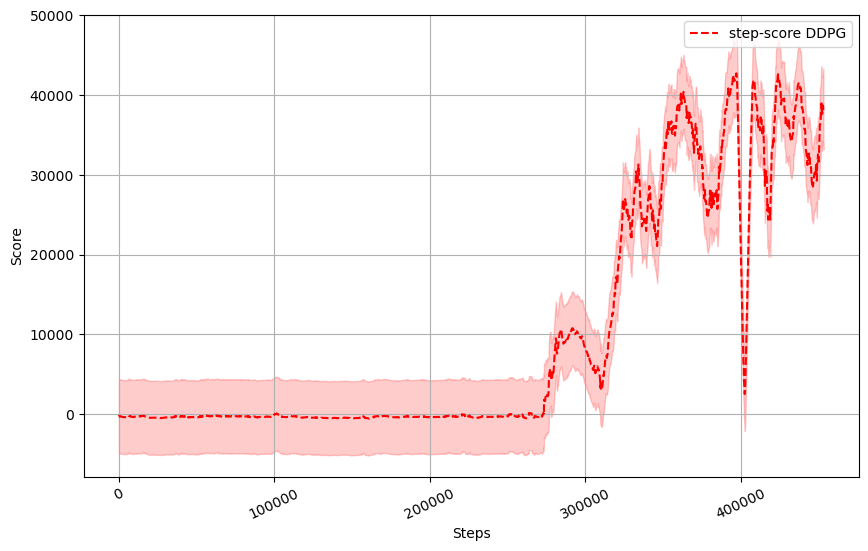

In [18]:
from scipy.ndimage import uniform_filter1d

# Inicializar listas vacías para los valores de x (steps) e y (score)
x = []
y = []

# Cargar los datos suavizados desde el archivo CSV
with open('./historial_juntos/historial_juntos_smoothed.csv', 'r', encoding='utf-8') as csvfile:
    next(csvfile)  # Saltar la cabecera
    lines = csv.reader(csvfile, delimiter=',')
    for row in lines:
        x.append(int(row[2]))  # Suponiendo que la columna de índice 2 corresponde a 'steps'
        y.append(float(row[0]))  # Suponiendo que la columna de índice 0 corresponde a 'score'

x=x[:-1500]
y=y[:-1500]

# Aplicar suavizado a los valores de y usando una media móvil
window_size = 20  # Tamaño de la ventana de suavizado
y_smoothed = uniform_filter1d(y, size=window_size)

# Calcular la desviación estándar para crear la sombra
std_dev = np.std(y - y_smoothed)

# Generar la gráfica con la curva suavizada y la sombra
plt.figure(figsize=(10, 6))
plt.plot(x, y_smoothed, color='r', linestyle='dashed', label="step-score DDPG")
plt.fill_between(x, np.array(y_smoothed) - std_dev, np.array(y_smoothed) + std_dev, color='r', alpha=0.2)

# Configuraciones adicionales de la gráfica
plt.xticks(rotation=25)
plt.xlabel('Steps')
plt.ylabel('Score')
#plt.title('Training Phase with Smoothed Curve', fontsize=20)
plt.grid()
plt.legend()
plt.show()